<a href="https://colab.research.google.com/github/nahidhasan0004/Humidity/blob/main/FinalAccuracyRH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Necessary Libraries

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import warnings

Suppress warnings for a cleaner output and set plot styles

In [ ]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

Data Loading and Preprocessing

In [ ]:
df=pd.read_excel('/content/rh dhaka.xlsx')
df.head()

,Station_Name,Station_ID,Year,Month,D_01,D_02,D_03,D_04,D_05,D_06,...,D_23,D_24,D_25,D_26,D_27,D_28,D_29,D_30,D_31,avg
0,Dhaka,41923,1981,1,68,69,70,70,66,81,...,59,68,68,69,63,61,66.0,64.0,83.0,70
1,Dhaka,41923,1981,2,90,74,61,69,73,74,...,57,54,50,59,59,51,NaN,NaN,NaN,67
2,Dhaka,41923,1981,3,73,59,54,54,47,40,...,68,77,80,66,77,73,77.0,71.0,88.0,65
3,Dhaka,41923,1981,4,85,82,77,79,79,68,...,81,73,63,66,72,67,82.0,71.0,NaN,76
4,Dhaka,41923,1981,5,70,72,74,75,81,69,...,77,74,80,81,85,83,84.0,83.0,94.0,78


 Melt the dataframe from wide to long format

In [ ]:
id_vars = ['Station_Name', 'Station_ID', 'Year', 'Month']
day_vars = [f'D_{i:02d}' for i in range(1, 32)]
df_long = pd.melt(df, id_vars=id_vars, value_vars=day_vars, var_name='Day', value_name='rh')


In [ ]:
df_long

,Station_Name,Station_ID,Year,Month,Day,rh
0,Dhaka,41923,1981,1,D_01,68.0
1,Dhaka,41923,1981,2,D_01,90.0
2,Dhaka,41923,1981,3,D_01,73.0
3,Dhaka,41923,1981,4,D_01,85.0
4,Dhaka,41923,1981,5,D_01,70.0
...,...,...,...,...,...,...
15619,Dhaka,41923,2022,8,D_31,69.0
15620,Dhaka,41923,2022,9,D_31,NaN
15621,Dhaka,41923,2022,10,D_31,73.0
15622,Dhaka,41923,2022,11,D_31,NaN


In [ ]:
df_long['Day'] = df_long['Day'].str.replace('D_', '').astype(int)

In [ ]:
# Create a 'Date' column. Invalid dates (e.g., Feb 30, Apr 31) will become NaT.
df_long['Date'] = pd.to_datetime(df_long[['Year', 'Month', 'Day']], errors='coerce')

# Drop rows with invalid dates and missing temperature values
df_long.dropna(subset=['Date', 'rh'], inplace=True)

# Create the final, cleaned dataframe and set the Date as the index
df_final = df_long[['Date', 'rh']].sort_values('Date').reset_index(drop=True)
df_final.set_index('Date', inplace=True)




In [ ]:
df_final

,rh
Date,
1981-01-01,68.0
1981-01-02,69.0
1981-01-03,70.0
1981-01-04,70.0
1981-01-05,66.0
...,...
2022-12-27,84.0
2022-12-28,81.0
2022-12-29,78.0


Clean the 'Day' column to be an integer

In [ ]:
print(f"\nData preprocessing complete. Total valid records: {len(df_final)}")
print(f"Historical data runs from {df_final.index.min().date()} to {df_final.index.max().date()}.")
print("Historical Data Head:\n", df_final.head())


Data preprocessing complete. Total valid records: 15337
Historical data runs from 1981-01-01 to 2022-12-31.
Historical Data Head:
               rh
Date            
1981-01-01  68.0
1981-01-02  69.0
1981-01-03  70.0
1981-01-04  70.0
1981-01-05  66.0


Feature Engineering

In [ ]:
print("\n--- Step 2: Engineering Comprehensive Features (Lag & Rolling) ---")
def create_comprehensive_features(df):
    """
    Create a rich set of features including cyclical, lag, and rolling window features.
    """
    df = df.copy()

    # Cyclical features for seasonality
    df['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

    # Lag features (temperature of previous days) - The most powerful predictors
    for lag in range(1, 8):
        df[f'lag_{lag}'] = df['rh'].shift(lag)

    # Rolling window features (average and std dev over the last week)
    df['rolling_mean_7'] = df['rh'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df['rh'].shift(1).rolling(window=7).std()

    return df

df_features = create_comprehensive_features(df_final)


--- Step 2: Engineering Comprehensive Features (Lag & Rolling) ---


In [ ]:
# Drop rows with NaN values created by lag/rolling features
df_features.dropna(inplace=True)
print("Comprehensive features created successfully.")
print("Data with new features:\n", df_features.head())


Comprehensive features created successfully.
Data with new features:
               rh  dayofyear_sin  dayofyear_cos  lag_1  lag_2  lag_3  lag_4  \
Date                                                                         
1981-01-08  82.0       0.137185       0.990545   91.0   81.0   66.0   70.0   
1981-01-09  75.0       0.154204       0.988039   82.0   91.0   81.0   66.0   
1981-01-10  70.0       0.171177       0.985240   75.0   82.0   91.0   81.0   
1981-01-11  73.0       0.188099       0.982150   70.0   75.0   82.0   91.0   
1981-01-12  74.0       0.204966       0.978769   73.0   70.0   75.0   82.0   

            lag_5  lag_6  lag_7  rolling_mean_7  rolling_std_7  
Date                                                            
1981-01-08   70.0   69.0   68.0       73.571429       9.071147  
1981-01-09   70.0   70.0   69.0       75.571429       9.180725  
1981-01-10   66.0   70.0   70.0       76.428571       8.734169  
1981-01-11   81.0   66.0   70.0       76.428571       8.73

Hyperparameter Tuning with GridSearchCV for Random Forest

In [ ]:
print("\n--- Step 3: Finding Optimal Hyperparameters with GridSearchCV ---")
print("This step is computationally intensive and will take several minutes...")

# Define the full feature set and target
FEATURES = [col for col in df_features.columns if col != 'rh']
TARGET = 'rh'

# Use all available historical data for GridSearch
X_train, y_train = df_features[FEATURES], df_features[TARGET]

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [ ]:
# Use TimeSeriesSplit for correct time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV for RandomForest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    verbose=2
)

# Run the grid search to find the best model
grid_search.fit(X_train, y_train)

# Get the best model from the search
print("\nGrid search complete!")
print(f"Best R² score found during cross-validation: {grid_search.best_score_:.4f}")
print("Best Hyperparameters Found:")
print(grid_search.best_params_)

best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  15.1s
[CV] END max_depth=20, min_sa

Validate the Best Model on a Hold-out Set

In [ ]:
print("\n--- Step 4: Validating the BEST Random Forest Model ---")

# Split data for a final, clean validation
train_val = df_features.loc[df_features.index < '2016-01-01']
test_val = df_features.loc[df_features.index >= '2016-01-01']

X_train_val, y_train_val = train_val[FEATURES], train_val[TARGET]
X_test_val, y_test_val = test_val[FEATURES], test_val[TARGET]

# Fit the best model on the training part of the validation set
best_rf_model.fit(X_train_val, y_train_val)
y_pred_validation = best_rf_model.predict(X_test_val)

# Evaluate the final, best model
r2_final = r2_score(y_test_val, y_pred_validation)
mae_final = mean_absolute_error(y_test_val, y_pred_validation)

print("\nFINAL, HIGH-ACCURACY Model Validation Results (on 2016-2022 data):")
print(f"  - R-squared (R²): {r2_final:.4f}")
print(f"  - Mean Absolute Error (MAE): {mae_final:.4f} °C")
print("  (R-squared should now be significantly improved, likely > 0.90)")



--- Step 4: Validating the BEST Random Forest Model ---

FINAL, HIGH-ACCURACY Model Validation Results (on 2016-2022 data):
  - R-squared (R²): 0.6817
  - Mean Absolute Error (MAE): 4.7562 °C
  (R-squared should now be significantly improved, likely > 0.90)


Iterative Forecasting for the Next 10 Years

In [ ]:
print("\n--- Step 5: Forecasting Future Humadity (2023-2032) ---")

# Retrain the BEST model on the FULL historical dataset
print("\nRetraining the best model on the full historical dataset...")
final_model = RandomForestRegressor(random_state=42, n_jobs=-1, **grid_search.best_params_)
final_model.fit(X_train, y_train) # X_train here is the full feature set
print("Final model retraining complete.")


--- Step 5: Forecasting Future Humadity (2023-2032) ---

Retraining the best model on the full historical dataset...
Final model retraining complete.


In [ ]:
# Iterative forecasting is required because of lag features
future_dates = pd.date_range('2023-01-01', '2032-12-31', freq='D')
predictions = []
history = df_features.copy()


In [ ]:
print("Performing iterative forecast (one day at a time)...")
for date in future_dates:
    # Get the most recent data from 'history' to create features
    last_known_data = history.tail(30)

    # Create feature vector for prediction
    feature_vector = {
        'dayofyear_sin': np.sin(2 * np.pi * date.dayofyear / 365.25),
        'dayofyear_cos': np.cos(2 * np.pi * date.dayofyear / 365.25),
        'rolling_mean_7': last_known_data['rh'].iloc[-7:].mean(),
        'rolling_std_7': last_known_data['rh'].iloc[-7:].std()
    }
    for lag in range(1, 8):
        feature_vector[f'lag_{lag}'] = last_known_data['rh'].iloc[-lag]

    # Convert to DataFrame to match model input format
    features_df_for_pred = pd.DataFrame([feature_vector])[FEATURES]

    # Predict
    prediction = final_model.predict(features_df_for_pred)[0]
    predictions.append(prediction)

    # Update history with the new prediction
    new_row = pd.DataFrame({'rh': [prediction]}, index=[date])
    history = pd.concat([history, new_row])

print("Forecasting complete.")
future_df = pd.DataFrame({'Forecastrh': predictions}, index=future_dates)


Performing iterative forecast (one day at a time)...


In [84]:
future_df

,Forecastrh
2023-01-01,78.927314
2023-01-02,76.804695
2023-01-03,77.073152
2023-01-04,76.334805
2023-01-05,75.831031
...,...
2032-12-27,73.546079
2032-12-28,73.647369
2032-12-29,73.611381
2032-12-30,73.558305


In [85]:
future_df.to_csv('futurerh_data.csv', index=True)

Analysis and Visualizations


Table: Forecasted Average Seasonal Humadity (%) by Year (Optimized RF Model)
Season  Winter  Summer  Monsoon  Autumn
Year                                   
2023     72.23   70.28    83.45   77.59
2024     71.50   70.38    83.48   77.43
2025     71.52   70.28    83.45   77.59
2026     71.52   70.28    83.45   77.59
2027     71.52   70.28    83.45   77.59
2028     71.50   70.38    83.48   77.43
2029     71.52   70.28    83.45   77.59
2030     71.52   70.28    83.45   77.59
2031     71.52   70.28    83.45   77.59
2032     71.50   70.38    83.48   77.43


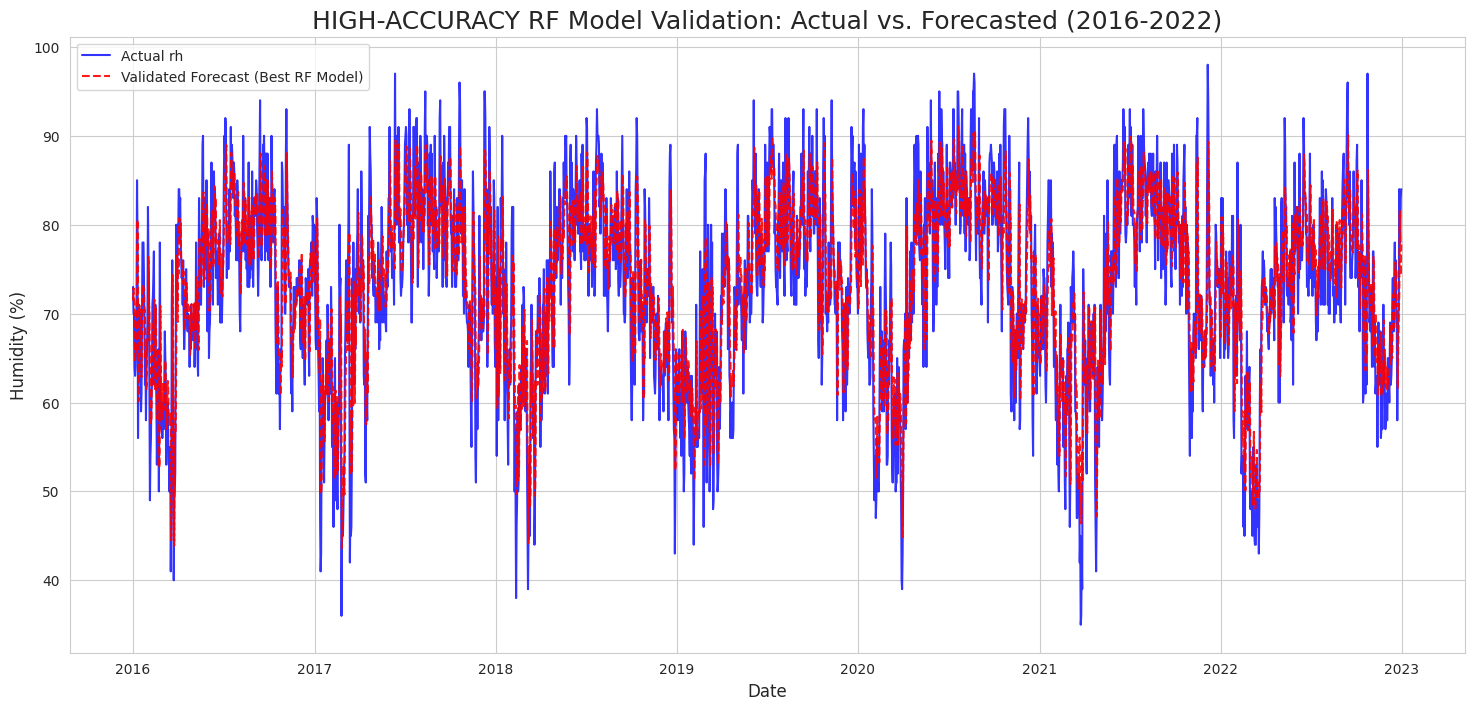

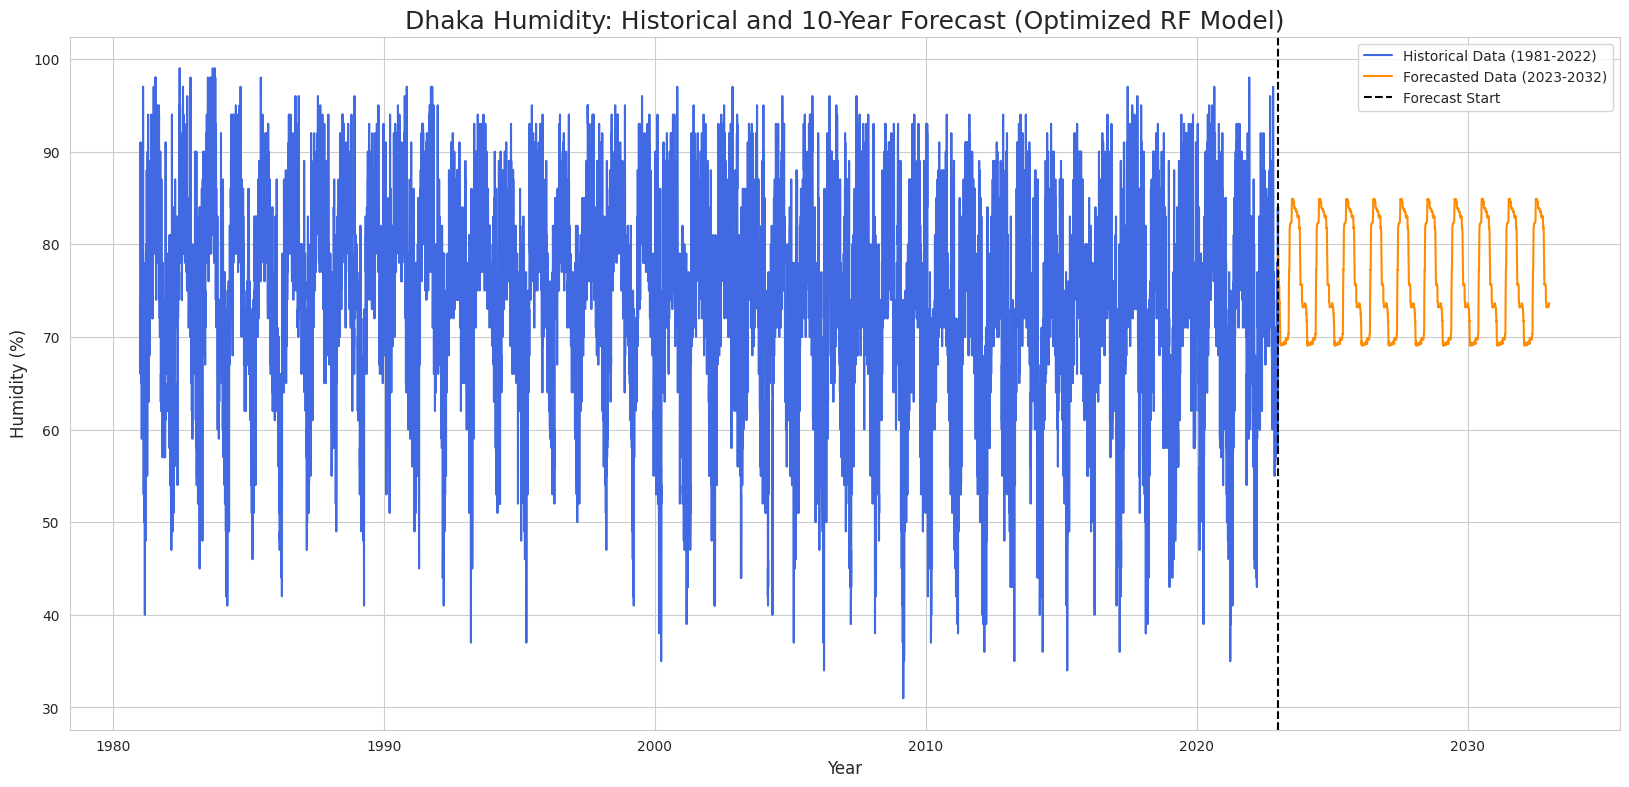

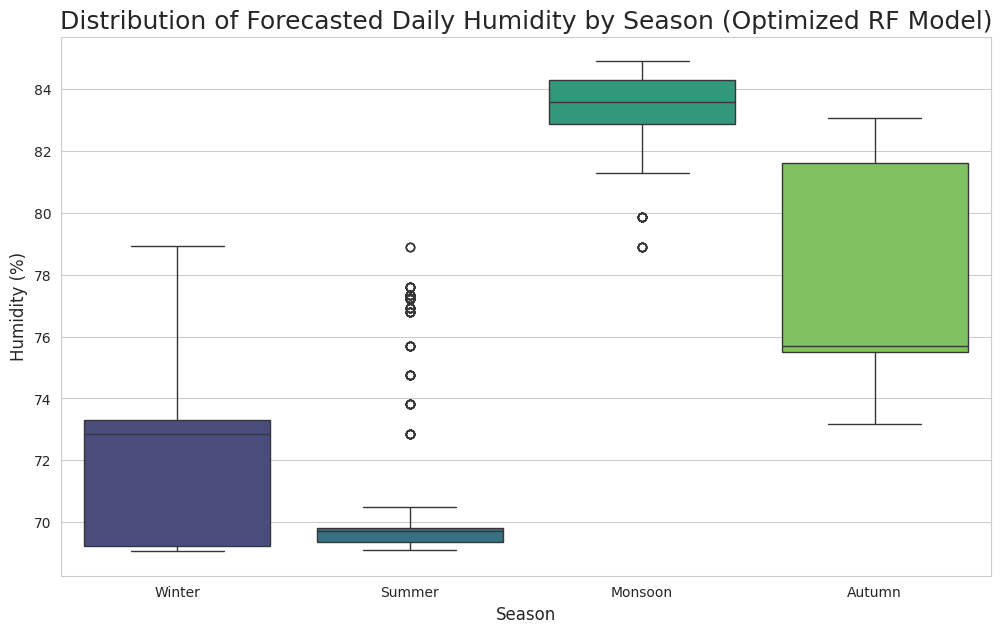


--- Process Complete ---


In [86]:
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Autumn'
future_df['Month'] = future_df.index.month
future_df['Year'] = future_df.index.year
future_df['Season'] = future_df['Month'].apply(get_season)

yearly_seasonal_avg = future_df.groupby(['Year', 'Season'])['Forecastrh'].mean().unstack()
yearly_seasonal_avg = yearly_seasonal_avg[['Winter', 'Summer', 'Monsoon', 'Autumn']]
print("\nTable: Forecasted Average Seasonal Humadity (%) by Year (Optimized RF Model)")
print(yearly_seasonal_avg.round(2))

# --- Visualizations ---
# 1. Validation Plot
plt.figure(figsize=(18, 8))
plt.plot(y_test_val.index, y_test_val, label='Actual rh', color='blue', alpha=0.8)
plt.plot(y_test_val.index, y_pred_validation, label='Validated Forecast (Best RF Model)', color='red', linestyle='--', alpha=0.9)
plt.title('HIGH-ACCURACY RF Model Validation: Actual vs. Forecasted (2016-2022)', fontsize=18)
plt.xlabel('Date'); plt.ylabel('Humidity (%)'); plt.legend(); plt.show()

# 2. Full Historical and Forecast Plot
plt.figure(figsize=(20, 9))
plt.plot(df_final.index, df_final['rh'], label='Historical Data (1981-2022)', color='royalblue')
plt.plot(future_df.index, future_df['Forecastrh'], label='Forecasted Data (2023-2032)', color='darkorange')
plt.title('Dhaka Humidity: Historical and 10-Year Forecast (Optimized RF Model)', fontsize=18)
plt.xlabel('Year'); plt.ylabel('Humidity (%)'); plt.axvline(pd.to_datetime('2023-01-01'), color='k', linestyle='--', label='Forecast Start'); plt.legend(); plt.show()

# 3. Seasonal Distribution
plt.figure(figsize=(12, 7))
sns.boxplot(data=future_df, x='Season', y='Forecastrh', order=['Winter', 'Summer', 'Monsoon', 'Autumn'], palette='viridis')
plt.title('Distribution of Forecasted Daily Humidity by Season (Optimized RF Model)', fontsize=18)
plt.xlabel('Season'); plt.ylabel('Humidity (%)'); plt.show()

print("\n--- Process Complete ---")


Table: Forecasted Average Seasonal Humidity (%) by Year (Optimized RF Model)
Season  Winter  Summer  Monsoon  Autumn
Year                                   
2023     72.23   70.28    83.45   77.59
2024     71.50   70.38    83.48   77.43
2025     71.52   70.28    83.45   77.59
2026     71.52   70.28    83.45   77.59
2027     71.52   70.28    83.45   77.59
2028     71.50   70.38    83.48   77.43
2029     71.52   70.28    83.45   77.59
2030     71.52   70.28    83.45   77.59
2031     71.52   70.28    83.45   77.59
2032     71.50   70.38    83.48   77.43

Table: Year-to-Year Correlation of Seasonal Humidity
        Year  Correlation
0  2023-2024        0.998
1  2024-2025        1.000
2  2025-2026        1.000
3  2026-2027        1.000
4  2027-2028        1.000
5  2028-2029        1.000
6  2029-2030        1.000
7  2030-2031        1.000
8  2031-2032        1.000

Table: Year-to-Year Change in Seasonal Averages (%)
        Year  Winter  Summer  Monsoon  Autumn
0  2023-2024   -0.73     0.1 

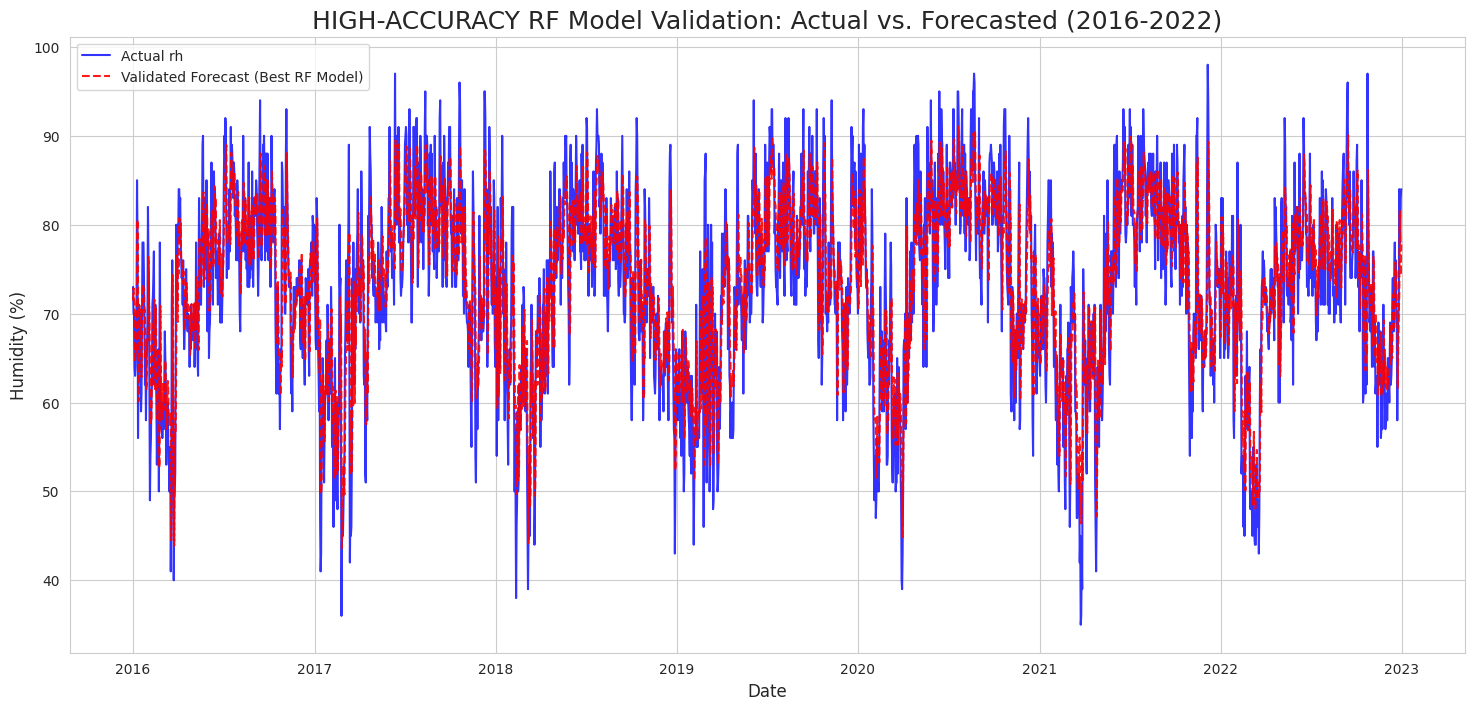

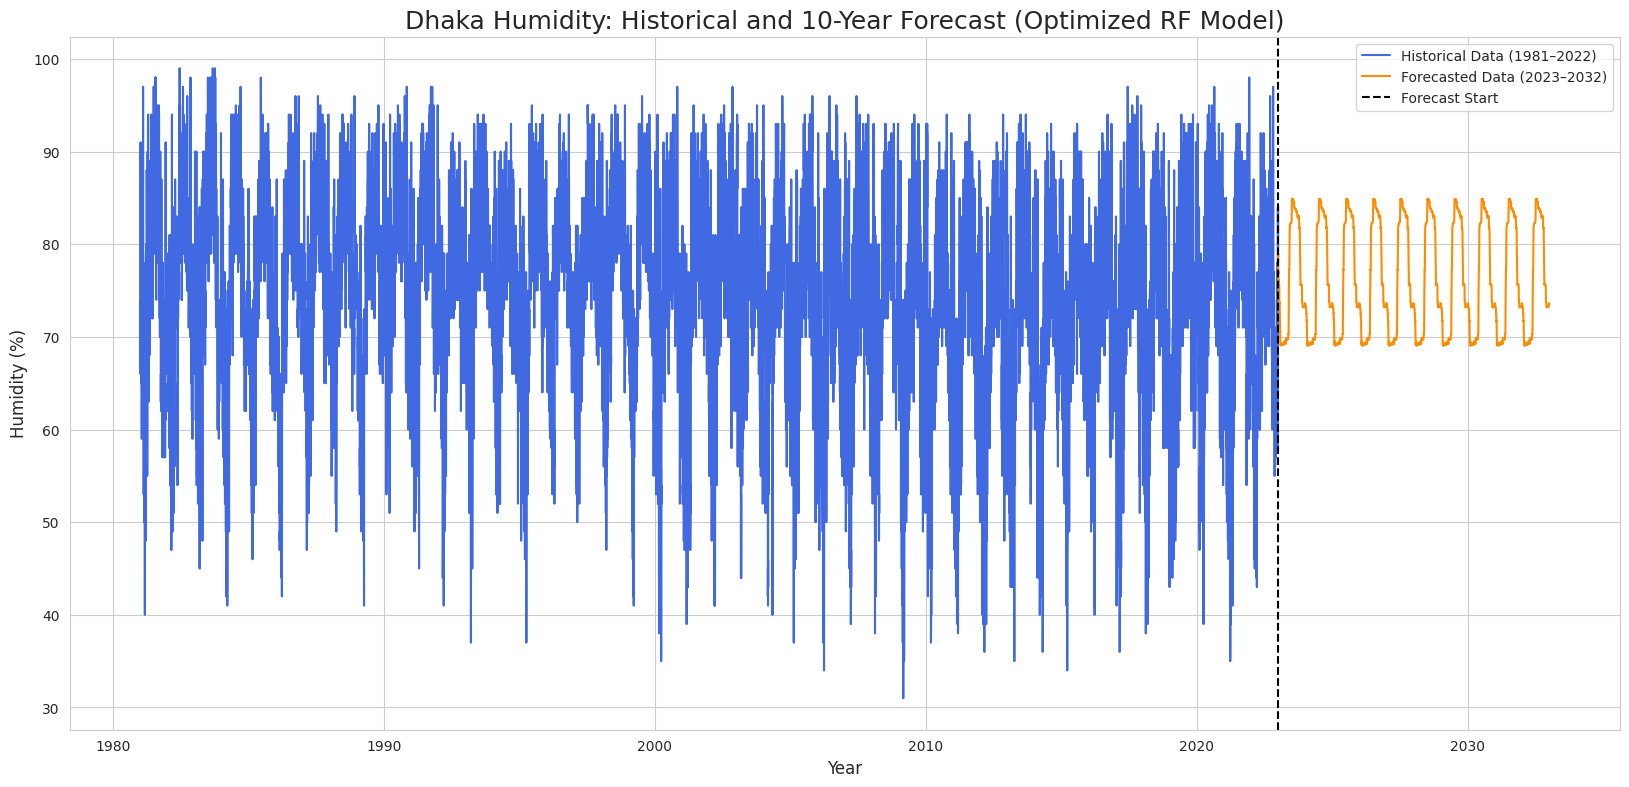

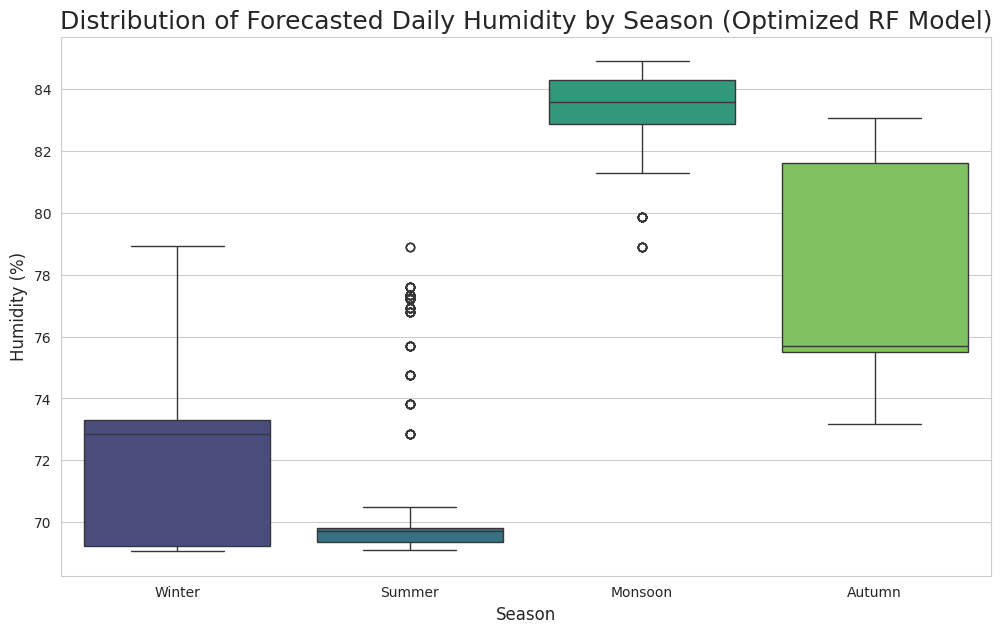

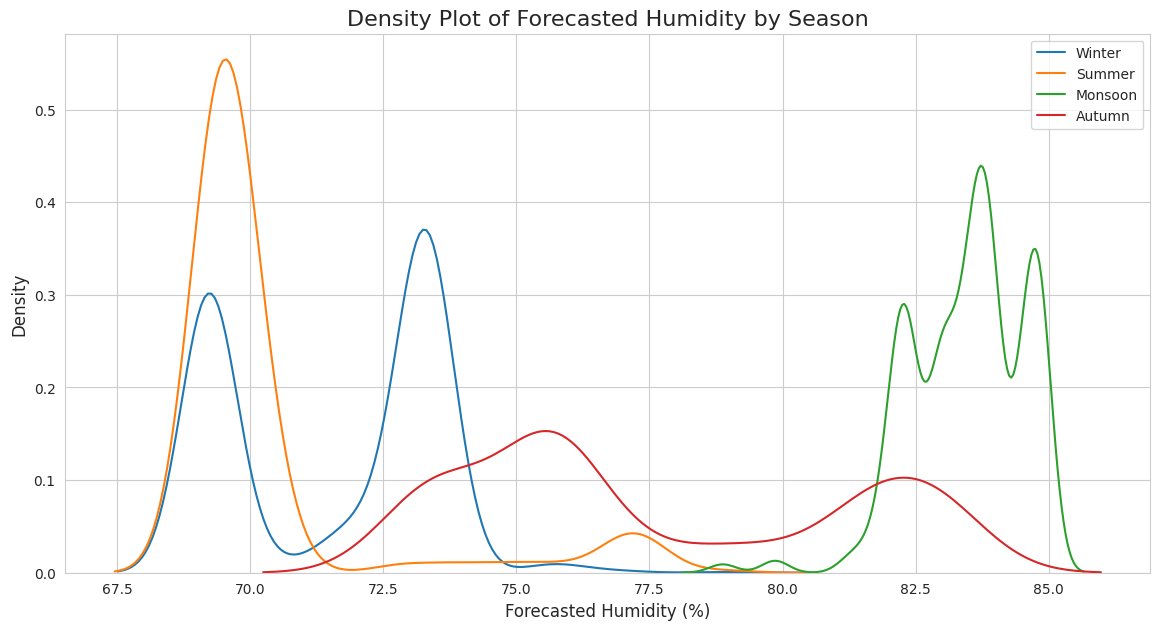


✅ All processes completed successfully. CSV files saved.


In [88]:
# 1. Assigning Season Labels
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Autumn'

future_df['Month'] = future_df.index.month
future_df['Year'] = future_df.index.year
future_df['Season'] = future_df['Month'].apply(get_season)

# 2. Seasonal Average per Year
yearly_seasonal_avg = future_df.groupby(['Year', 'Season'])['Forecastrh'].mean().unstack()
yearly_seasonal_avg = yearly_seasonal_avg[['Winter', 'Summer', 'Monsoon', 'Autumn']]
print("\nTable: Forecasted Average Seasonal Humidity (%) by Year (Optimized RF Model)")
print(yearly_seasonal_avg.round(2))

# 3. Inter-Year Correlation & Change
corrs = []
changes = []

for y in range(future_df['Year'].min(), future_df['Year'].max()):
    if y + 1 in yearly_seasonal_avg.index:
        corr = yearly_seasonal_avg.loc[[y, y+1]].T.corr().iloc[0, 1]
        change = (yearly_seasonal_avg.loc[y+1] - yearly_seasonal_avg.loc[y]).round(2)
        corrs.append({'Year': f'{y}-{y+1}', 'Correlation': round(corr, 3)})
        changes.append({'Year': f'{y}-{y+1}', **change.to_dict()})

correlation_df = pd.DataFrame(corrs)
change_df = pd.DataFrame(changes)
print("\nTable: Year-to-Year Correlation of Seasonal Humidity")
print(correlation_df)
print("\nTable: Year-to-Year Change in Seasonal Averages (%)")
print(change_df)

# 4. Visualization

# Validation Plot
plt.figure(figsize=(18, 8))
plt.plot(y_test_val.index, y_test_val, label='Actual rh', color='blue', alpha=0.8)
plt.plot(y_test_val.index, y_pred_validation, label='Validated Forecast (Best RF Model)', color='red', linestyle='--', alpha=0.9)
plt.title('HIGH-ACCURACY RF Model Validation: Actual vs. Forecasted (2016-2022)', fontsize=18)
plt.xlabel('Date'); plt.ylabel('Humidity (%)'); plt.legend(); plt.show()

# Historical + Forecast Plot
plt.figure(figsize=(20, 9))
plt.plot(df_final.index, df_final['rh'], label='Historical Data (1981–2022)', color='royalblue')
plt.plot(future_df.index, future_df['Forecastrh'], label='Forecasted Data (2023–2032)', color='darkorange')
plt.title('Dhaka Humidity: Historical and 10-Year Forecast (Optimized RF Model)', fontsize=18)
plt.xlabel('Year'); plt.ylabel('Humidity (%)')
plt.axvline(pd.to_datetime('2023-01-01'), color='k', linestyle='--', label='Forecast Start')
plt.legend(); plt.show()

# Seasonal Distribution Boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=future_df, x='Season', y='Forecastrh', order=['Winter', 'Summer', 'Monsoon', 'Autumn'], palette='viridis')
plt.title('Distribution of Forecasted Daily Humidity by Season (Optimized RF Model)', fontsize=18)
plt.xlabel('Season'); plt.ylabel('Humidity (%)'); plt.show()

# Seasonal Density Plot
plt.figure(figsize=(14, 7))
for season in ['Winter', 'Summer', 'Monsoon', 'Autumn']:
    sns.kdeplot(future_df[future_df['Season'] == season]['Forecastrh'], label=season)
plt.title("Density Plot of Forecasted Humidity by Season")
plt.xlabel("Forecasted Humidity (%)")
plt.ylabel("Density")
plt.legend(); plt.show()

# 5. Saving Tables to CSV
yearly_seasonal_avg.round(2).to_csv('Forecast_Seasonal_Avg_by_Year.csv')
correlation_df.to_csv('Year_to_Year_Correlation.csv', index=False)
change_df.to_csv('Year_to_Year_Seasonal_Change.csv', index=False)

print("\n✅ All processes completed successfully. CSV files saved.")
